## Predict No Shows for Medical Appointments

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports for data
import numpy as np
import pandas as pd
import os

# for metrics, preprocessing
import sklearn


# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


In [8]:
import os
os.getcwd()
os.chdir('/Users/vivekkathula/Documents/Edv py projects/P6/')
#os.listdir()

In [9]:
train = pd.read_csv("train.csv")
test =pd.read_csv("test_share.csv")
medical = pd.read_csv("medical_history.csv")
demographic=pd.read_csv("demographic_details.csv")

In [10]:
df_1=pd.merge(train,medical,on=['PatientId'],how='inner').copy()
df_train=pd.merge(df_1,demographic,on=['PatientId'],how='inner').copy()

In [11]:
df_2=pd.merge(test,medical,on=['PatientId'],how='inner').copy()
df_test=pd.merge(df_2,demographic,on=['PatientId'],how='inner').copy()

In [12]:
num_cols = ['Age']
cat_cols = ['Handcap','Neighbourhood']
binary_cols = ['SMS_received','Hipertension','Diabetes','Alcoholism','SMS_received','Gender','Scholarship']
date_cols =['ScheduledDay','AppointmentDay']

## Create Valid Set

In [13]:
df_train['No-show']=np.where(df_train['No-show']=='Yes',1,0)

In [14]:
# stratified split is what i prefer but there are cats that came only once in train
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df_train, test_size=0.2, random_state=42)

## Custom Tranformers

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

ScheduledDay_ix, AppointmentDay_ix, = 2,3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_Adow_sin = True): # no *args or **kargs
        self.add_Adow_sin = add_Adow_sin
        
    def fit(self, X, y=None):
        return self # nothing else to do 
    
    def transform(self, X):
        #Sdate = pd.to_datetime(X["ScheduledDay"], format='%Y-%m-%dT%H:%M:%SZ')
        #Adate = pd.to_datetime(X["AppointmentDay"], format='%Y-%m-%dT%H:%M:%SZ')
        Sdate = pd.to_datetime(X[:,2], format='%Y-%m-%dT%H:%M:%SZ')
        Adate = pd.to_datetime(X[:,3], format='%Y-%m-%dT%H:%M:%SZ')
        
        A_day=Adate.day
        A_dofweek=Adate.dayofweek
        A_month=Adate.month
        
        S_hr=Sdate.hour
        S_day=Sdate.day
        S_dofweek=Sdate.dayofweek
        S_month=Sdate.month
        
        sin_S_hr = np.sin(2 * np.pi * (S_hr-S_hr.min())/(S_hr.max()-S_hr.min()))
        cos_S_hr = np.cos(2 * np.pi * (S_hr-S_hr.min())/(S_hr.max()-S_hr.min()))
        
        sin_S_day = np.sin(2 * np.pi * (S_day-S_day.min())/(S_day.max()-S_day.min()))
        cos_S_day = np.cos(2 * np.pi * (S_day-S_day.min())/(S_day.max()-S_day.min()))
        
        sin_S_dofweek=np.sin(2 * np.pi * (S_dofweek-S_dofweek.min())/(S_dofweek.max()-S_dofweek.min()))
        cos_S_dofweek=np.cos(2 * np.pi * (S_dofweek-S_dofweek.min())/(S_dofweek.max()-S_dofweek.min()))
        
        sin_S_month = np.sin(2 * np.pi * (S_month-S_month.min())/(S_month.max()-S_month.min()))
        cos_S_month = np.cos(2 * np.pi * (S_month-S_month.min())/(S_month.max()-S_month.min()))
        
        sin_A_day= np.sin(2 * np.pi * (A_day-A_day.min())/(A_day.max()-A_day.min()))
        cos_A_day= np.sin(2 * np.pi * (A_day-A_day.min())/(A_day.max()-A_day.min()))
        
        sin_A_dofweek = np.sin(2 * np.pi * (A_dofweek-S_dofweek.min())/(A_dofweek.max()-A_dofweek.min()))
        cos_A_dofweek = np.cos(2 * np.pi * (A_dofweek-S_dofweek.min())/(A_dofweek.max()-A_dofweek.min()))
        
        sin_A_month = np.sin(2 * np.pi * (A_month-A_month.min())/(A_month.max()-A_month.min()))
        cos_A_month = np.cos(2 * np.pi * (A_month-A_month.min())/(A_month.max()-A_month.min()))
        
        return np.c_[sin_S_hr, sin_S_hr, sin_S_day, cos_S_day,sin_S_dofweek,cos_S_dofweek,
                     sin_S_month,cos_S_month,sin_A_day,cos_A_day,sin_A_dofweek,cos_A_dofweek,                    
                     sin_A_month,cos_A_month]

attr_adder = CombinedAttributesAdder()
data_extra_attribs = attr_adder.transform(train_set.values)
data_extra_attribs.shape

(79592, 14)

## Transformation Pipeline

In [16]:
# date cols
# for second attempt i opened std scaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

date_cols=["PatientId","AppointmentID","ScheduledDay","AppointmentDay"]
df_train_dates=train_set[date_cols].copy()

date_pipeline = Pipeline([            
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

df_train_dates_tr = date_pipeline.fit_transform(df_train_dates)
df_train_dates_tr.shape

(79592, 14)

In [17]:
# numcols
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_cols=["Age"]
df_train_num=train_set[num_cols].copy()

num_pipeline = Pipeline([            
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler()),
])

df_train_num_tr = num_pipeline.fit_transform(df_train_num)
df_train_num_tr.shape

(79592, 1)

In [18]:
#Binarycols
df_train_bin=train_set[binary_cols].copy()
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder(drop="first")

df_train_bin_tr = cat_encoder.fit_transform(df_train_bin)
df_train_bin_tr.shape

(79592, 7)

In [19]:
#catcols, not binary
df_train_cat=train_set[cat_cols].copy()
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()

df_train_cat_tr = cat_encoder.fit_transform(df_train_cat)
df_train_cat_tr.shape

(79592, 86)

In [20]:
from sklearn.compose import ColumnTransformer 

date_attribs =["PatientId","AppointmentID",'ScheduledDay','AppointmentDay']
num_attribs = ["Age"]
cat_attribs = ['Handcap','Neighbourhood']
binary_attribs=['SMS_received','Hipertension','Diabetes','Alcoholism','SMS_received','Gender','Scholarship']
     
full_pipeline = ColumnTransformer([
    ("date.time", date_pipeline, date_attribs), #14
    ("num_cols", num_pipeline, num_attribs),    # 1
    ("binary_cols",OneHotEncoder(drop="first"),binary_attribs),#7
    ("cat_cols", OneHotEncoder(), cat_attribs), #86 (81+5)
])
# for second attempt i opened std scaler and ran

In [21]:
# for second attempt i opened std scaler
X_train = train_set.drop(["No-show"],axis=1).copy()
y_train = train_set["No-show"].copy()

X_valid = valid_set.drop(["No-show"],axis=1).copy()
y_valid = valid_set["No-show"].copy()

In [22]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_valid_prepared = full_pipeline.transform(X_valid)

X_train_prepared.shape, X_valid_prepared.shape

((79592, 108), (19898, 108))

In [23]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0,max_iter=1000)
log_reg.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train_prepared, y_train,scoring="roc_auc", cv=10)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=log_reg.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.66402629 0.65948565 0.65321063 0.66235604 0.6663374  0.65841416
 0.64937701 0.68455167 0.6563332  0.67042076]


0.6730063249783274

### I felt it could have been imbalanced data, so tried diff class weights too

In [28]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0, class_weight="balanced",max_iter=1000)
log_reg.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train_prepared, y_train,scoring="roc_auc", cv=10)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=log_reg.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.66525653 0.66051445 0.65559921 0.66226548 0.66638912 0.66002614
 0.65000487 0.68524213 0.65869118 0.67074579]


0.636112193756763

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier()

rf_clf.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, X_train_prepared, y_train,scoring="roc_auc", cv=3)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=rf_clf.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.7252639  0.72815362 0.7306993 ]


0.7385207164661156

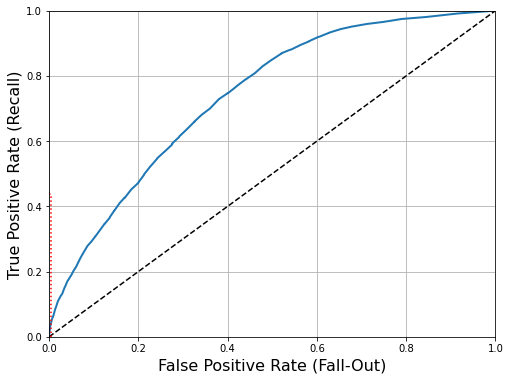

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")                           
plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(class_weight="balanced")

rf_clf.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, X_train_prepared, y_train,scoring="roc_auc", cv=3)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=rf_clf.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.72396271 0.72993727 0.73261047]


0.7382216300092952

In [34]:
# for second attempt i opened std scaler

xgb_clf=XGBClassifier()

xgb_clf.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_clf, X_train_prepared, y_train,scoring="roc_auc", cv=3)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=xgb_clf.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.70451044 0.70218597 0.70589894]


0.7145744619379006

In [45]:
xgb_clf=XGBClassifier(scale_pos_weight=100)

xgb_clf.fit(X_train_prepared, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_clf, X_train_prepared, y_train,scoring="roc_auc", cv=3)
print("roc-auc:  ",scores)

from sklearn.metrics import roc_auc_score
y_pred=xgb_clf.predict_proba(X_valid_prepared)[:,1]
y_true=y_valid

roc_auc_score(y_true,y_pred)

roc-auc:   [0.70047535 0.69858908 0.70218842]


0.7077574317133246

### RandomForest has the best score

I have attempted fine tune but it takes lot of time, and sincemy target is 0.66 i dropped the idea of Grid Search or Randomized Search

## Randomforest on Full train

In [24]:
# for second attempt i opened std scaler
X_train_full = df_train.drop(["No-show"],axis=1).copy()
y_train_full = df_train["No-show"].copy()

X_test = df_test.copy()


In [25]:
X_train_full_prepared = full_pipeline.fit_transform(X_train_full)
X_test_prepared = full_pipeline.transform(X_test)

X_train_full_prepared.shape, X_test_prepared.shape

((99490, 108), (11037, 108))

In [26]:
from sklearn.ensemble import RandomForestClassifier
final_rf_clf=RandomForestClassifier()

final_rf_clf.fit(X_train_full_prepared, y_train_full)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_rf_clf, X_train_full_prepared, y_train_full, scoring="roc_auc", cv=10)
print("roc-auc:  ",scores)


roc-auc:   [0.6610097  0.68438848 0.73103901 0.69549165 0.69426882 0.67942199
 0.64236451 0.69136904 0.70093939 0.71404435]


In [28]:
y_test_pred=final_rf_clf.predict_proba(X_test_prepared)[:,1]

In [31]:
mysubmission=test[["PatientId"]].copy()
mysubmission["No-show"]=y_test_pred
pd.DataFrame(mysubmission).to_csv("Submi_P6_EdvPy_KSV_S01.csv",index=False)